# Self Organizing Maps

Fitting self organizing maps to behavioural game data, imported from .csv files `q3dm1-path2`. We set the topology using `networkx` to be a cyclic graph of $int(\frac{k}{2})+int(\frac{k}{2})$ vertices, having the structure of two circles joined by edge. In the example the number $k=20$ is used, so for even number of vertices the number of points in each circle would be $\frac{k}{2}$.

The code shows the performance of batch version as well as on the original version. It plots the SOM weight in the real time during training with delay of $0.1 $ seconds.

Data points are visualized in *blue* and the SOM weights in *green* with the two extra edges to connect the dots to achieve circles, in *red* and *orange*.


In [2]:
def Two_Rings(matX, k):
    G1 = nx.generators.lattice.grid_2d_graph(int(k/2), 1, periodic=True)
    G1 = nx.convert_node_labels_to_integers(G1)
    G2 = nx.generators.lattice.grid_2d_graph(int(k/2), 1, periodic=True)
    G2 = nx.convert_node_labels_to_integers(G2)
    
    print(G1.nodes)
    print(G2.nodes)
    
    
    G =  nx.union(G1, G2, rename=('1-', '2-'))
    G.add_edge('1-0', '2-0')
    
    m, n = matX.shape
    smpl = rnd.choice(n, k, replace=False)
    for i, v in enumerate(G):
        G.nodes[v]['w'] = matX[:,smpl[i]]
    
    print(G.nodes)

    return G

In [3]:
import csv
import numpy as np
import numpy.random as rnd 
import networkx as nx


x,y,z = [], [], []

with open("q3dm1-path2.csv",'r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        x.append(float(row[0]))
        y.append(float(row[1]))
        z.append(float(row[2]))

data = np.vstack((x,y,z))
data.shape

matX = data

G = Two_Rings(matX, 20)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['1-0', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-0', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9']


<IPython.core.display.Javascript object>


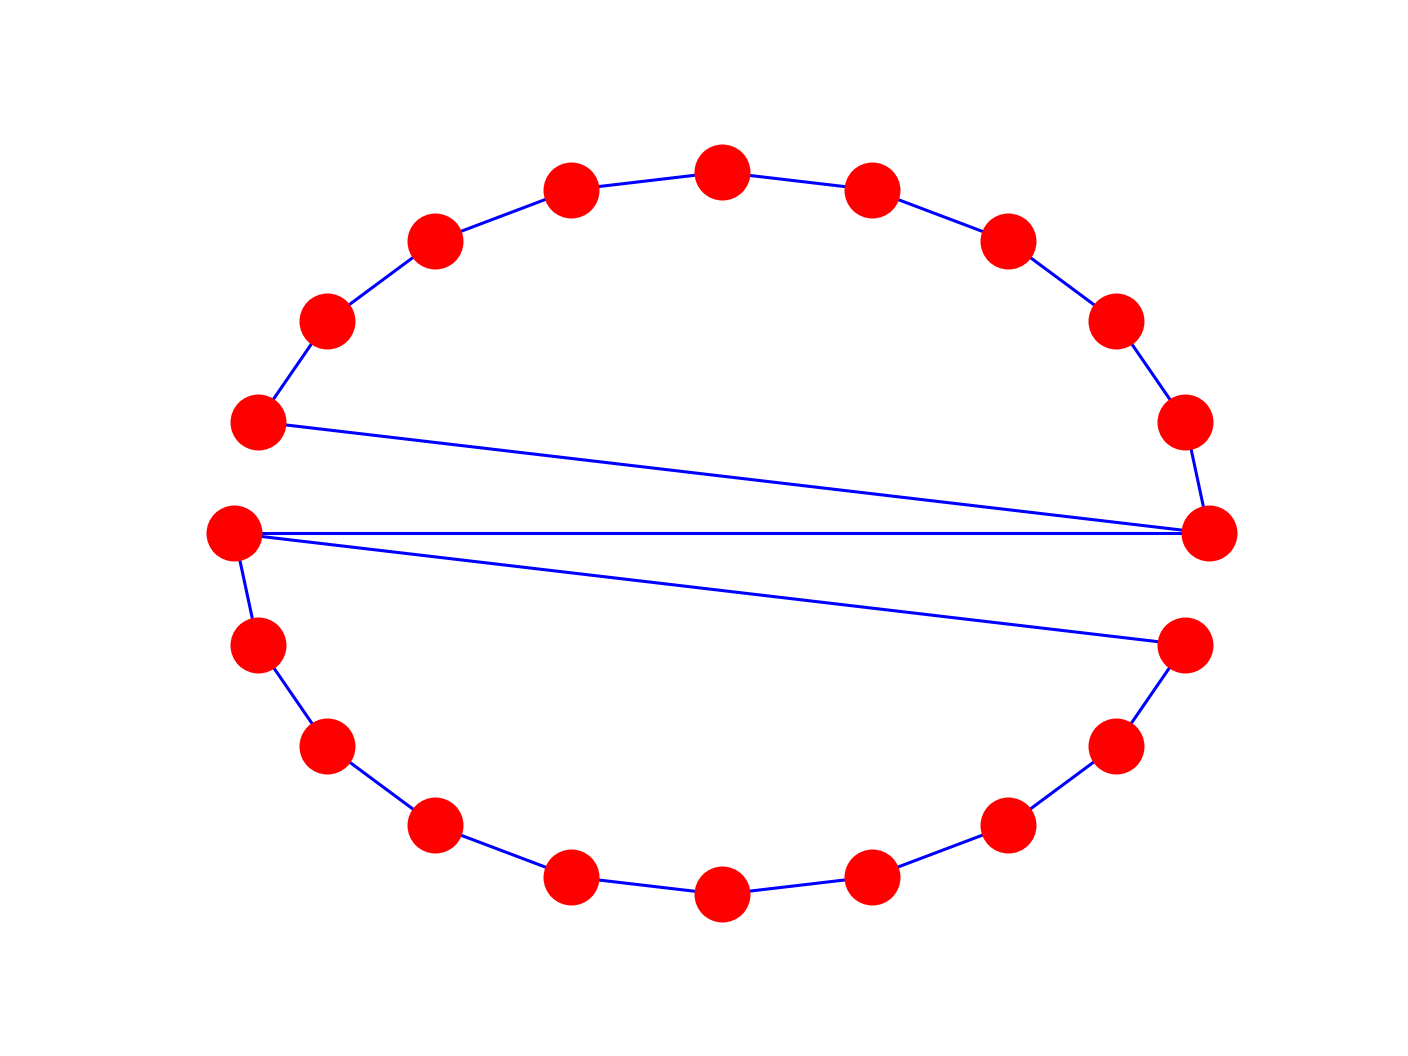

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.subplot(111)
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')

In [5]:
def trainSOM(matX, G, tmax=1000, sigma0=1., eta0=1., k=20):
    m, n = matX.shape
    Giterx, Gitery, Giterz = [], [], []
    # compute matrix of squared path length distances between neurons
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    # because this allows for easy squaring of its entries
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, n, size=tmax)
    
    for t in range(tmax):
        # sample a point x, i.e. a column of matrix X
        vecX = matX[:,smpl[t]]
        # determine the best matching unit
        b = np.argmin([np.sum((G.nodes[v]['w'] - vecX)**2) for v in G])
        # update the learning rate
        eta = eta0 * (1. - t/tmax)
        # update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)
        # update all weights
        
        #
        xi, yi, zi = [], [], []
        for i, v in enumerate(G):
            # evaluate neighborhood function
            h = np.exp(-0.5 * matD[b,i] / sigma**2)
            #print(h.shape, vecX.shape)
            G.nodes[v]['w'] += eta * h * (vecX - G.nodes[v]['w'])
            xi.append(G.nodes[v]['w'][0]), yi.append(G.nodes[v]['w'][1]), zi.append(G.nodes[v]['w'][2])
        
        Giterx.append(xi), Gitery.append(yi), Giterz. append(zi)
        
    return G, Giterx, Gitery, Giterz

In [6]:
### try to implement the batch version

def trainBatchSOM(matX, G, tmax=1000, sigma0=1., eta0=1., k=20):
    m, n = matX.shape
    Giterx, Gitery, Giterz = [], [], []
    # compute matrix of squared path length distances between neurons
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    # because this allows for easy squaring of its entries
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, n, size=tmax)
    
    for t in range(tmax):
        b = []
        
        for j in range(n):
            vecX = matX[:,j]
            
            # for each xj ∈ X, determine the best matching unit: create a list of best matching units
            b.append(np.argmin([np.sum((G.nodes[v]['w'] - vecX)**2) for v in G]))
        
        # update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)

        xi, yi, zi = [], [], []

        # update the weights of all neurons
        for i, v in enumerate(G): 
            h = np.zeros(n)
            
            for j1 in range(n):
                h[j1] = np.exp(-0.5 * matD[b[j1],i] / sigma**2)

            #print(" vecX, h ", vecX.shape, h.shape, len(b))

            nominator = np.dot (matX, h)
            denominator = np.sum(h)

            #print(nominator.shape)

            G.nodes[v]['w'] = nominator/ denominator
            xi.append(G.nodes[v]['w'][0]), yi.append(G.nodes[v]['w'][1]), zi.append(G.nodes[v]['w'][2])

        Giterx.append(xi), Gitery.append(yi), Giterz. append(zi)
        #print('Iteration number', t)
        
    return G, Giterx, Gitery, Giterz


In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time
import numpy.random as rnd 


def plot_SOM(data_path, k = 20, batch = 'none', max_iter = 1000):
    x = []
    y = []
    z = []

    with open(data_path,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=',')
        for row in plots:
            x.append(float(row[0]))
            y.append(float(row[1]))
            z.append(float(row[2]))

    data = np.vstack((x,y,z))
    data.shape

    matX = data

    SOM1 = Two_Rings(matX, k)
    #print(SOM1.nodes)

    fig = plt.figure()
    #fig.set_figheight(15)
    #fig.set_figwidth(15)
    ax = fig.add_subplot(111, projection='3d')
    plt.ion()

    fig.show()
    fig.canvas.draw()

    ax.clear()

    if batch == "yes":
        SOM1, Gx, Gy, Gz = trainBatchSOM(matX, SOM1, tmax = max_iter, k = k)
    else:
        SOM1, Gx, Gy, Gz = trainSOM(matX, SOM1, tmax = max_iter, k = k)
            
    nx.write_gpickle(SOM1, 'som.gpickle')
    
    for iter in np.linspace(1, max_iter-1, max_iter-1):
        ax.clear()
        ax.scatter(x , y, z, color = "blue", alpha=0.3, s = 1, label='The data first csv')
        
        ### add the points for plotting the structure
        f_p = Gx[int(iter)][0], Gy[int(iter)][0], Gz[int(iter)][0] 
        m_p = Gx[int(iter)][int(k/2)-1], Gy[int(iter)][int(k/2)-1], Gz[int(iter)][int(k/2)-1]
        
        #f_m = Gx[int(iter)][0, int(k/2)-1], Gy[int(iter)][0 , int(k/2)-1], Gz[int(iter)][0, int(k/2)-1]

        m_p_next = Gx[int(iter)][int(k/2)], Gy[int(iter)][int(k/2)], Gz[int(iter)][int(k/2)]
        l_p = Gx[int(iter)][k-1], Gy[int(iter)][k-1], Gz[int(iter)][k-1]
        
        ax.plot([f_p[0], m_p[0]], [f_p[1], m_p[1]], [f_p[2], m_p[2]], 'o-', color = "orange", alpha=0.3, label='cooneting f_p and m_p')
        ax.plot([l_p[0], m_p_next[0]], [l_p[1], m_p_next[1]], [l_p[2], m_p_next[2]], 'o-', color = "red", alpha=0.3, label='cooneting l_p and m_p')
        
        ax.plot(Gx[int(iter)], Gy[int(iter)], Gz[int(iter)], 'o-', color = "green", alpha=0.3, label='The data first csv')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylabel('z')
        plt.title('2 circles interconnected by edge: iteration = '+str(iter))
        plt.legend()
        #plt.show()
        fig.canvas.draw()
        time.sleep(0.1)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['1-0', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-0', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9']


<IPython.core.display.Javascript object>


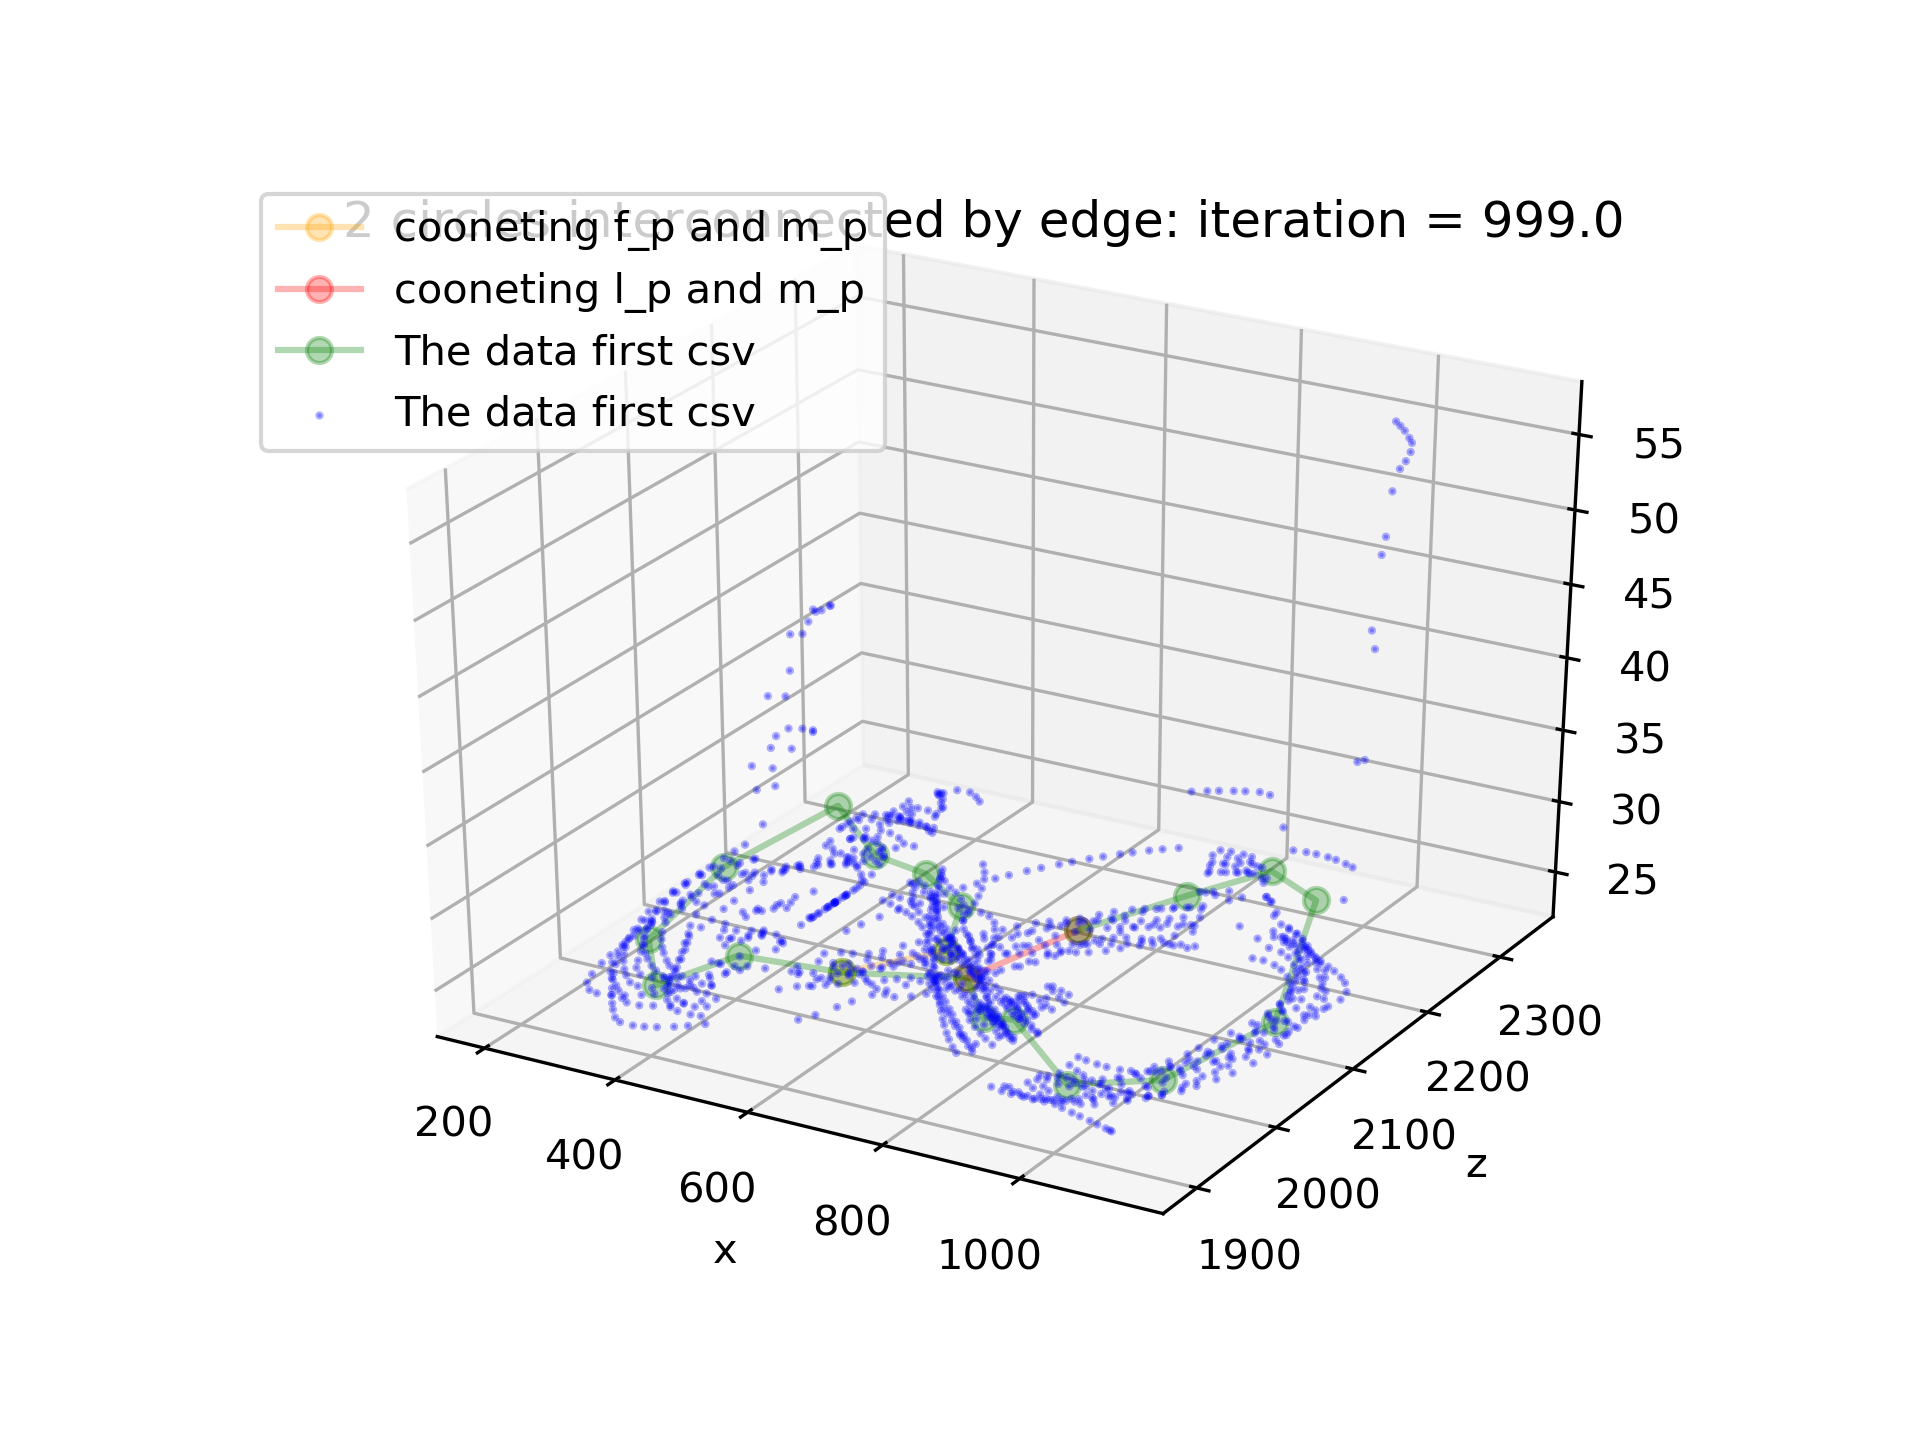

In [12]:
plot_SOM("q3dm1-path2.csv", batch = 'yes', max_iter = 1000)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['1-0', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-0', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9']


<IPython.core.display.Javascript object>


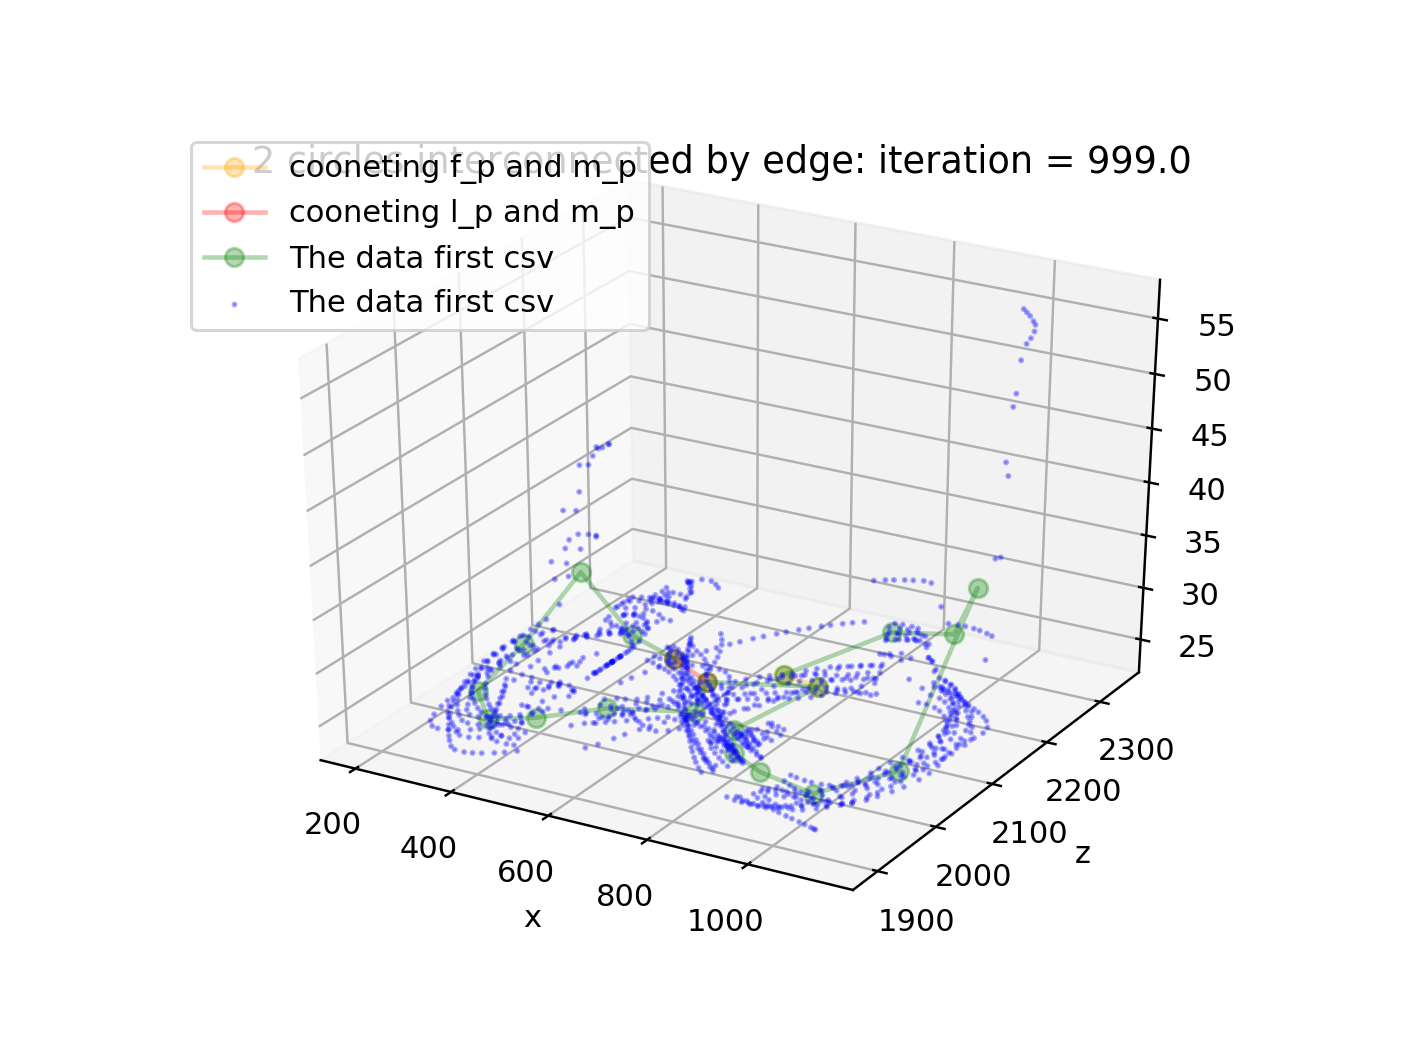

In [8]:
plot_SOM("q3dm1-path2.csv", max_iter = 1000)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['1-0', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-0', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9']


<IPython.core.display.Javascript object>


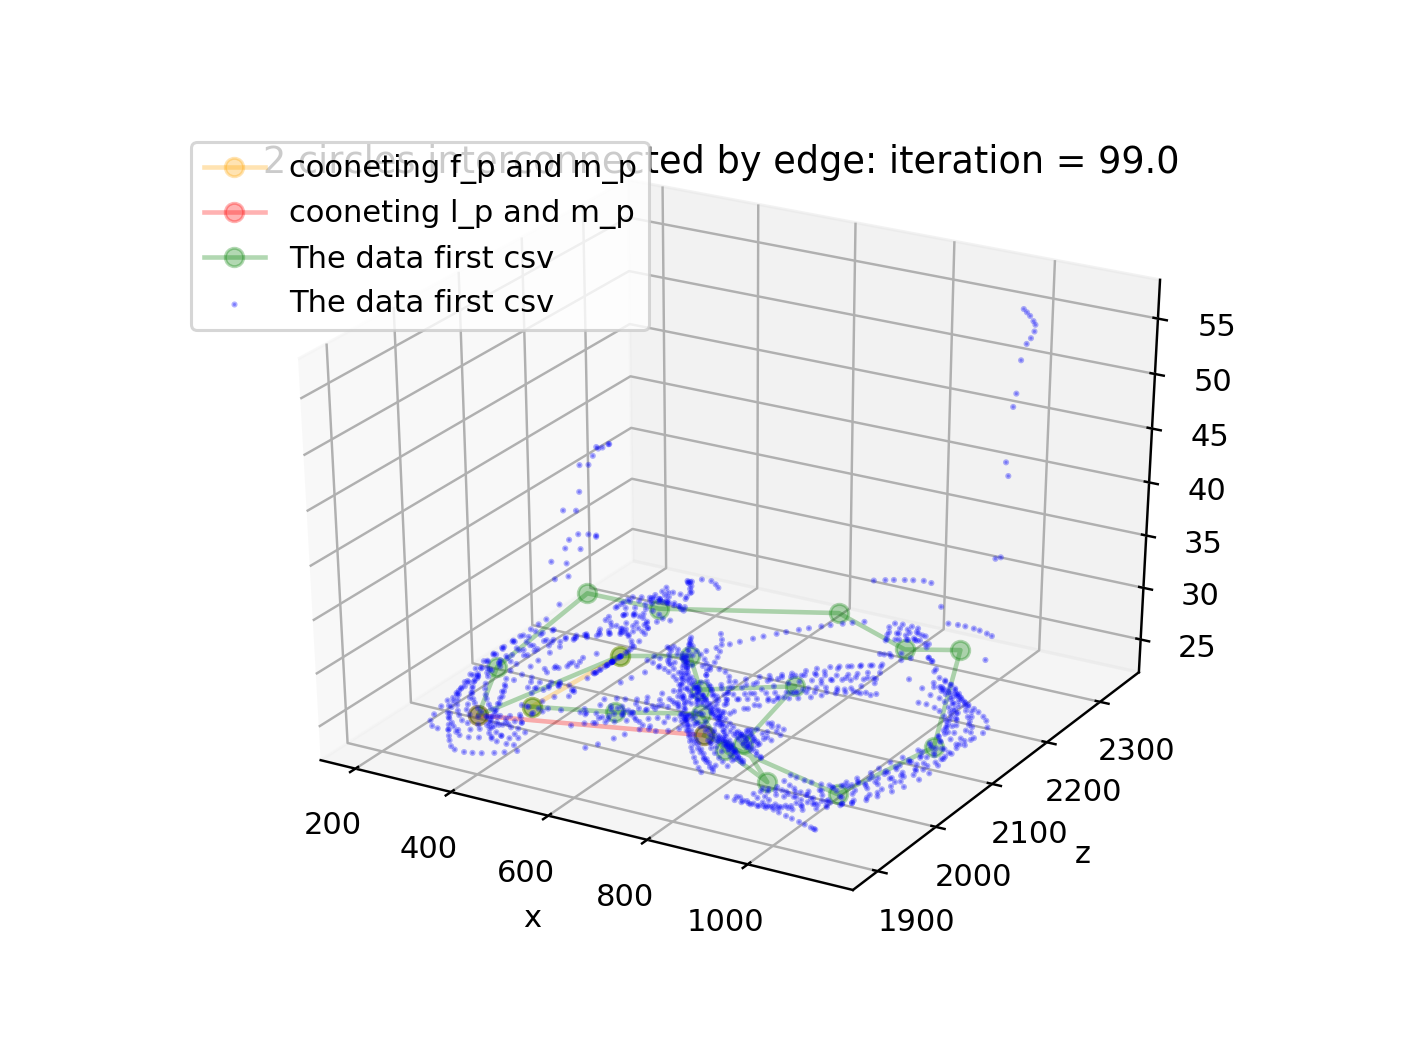

In [9]:
plot_SOM("q3dm1-path2.csv", batch = 'yes', max_iter = 100)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['1-0', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-0', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9']


<IPython.core.display.Javascript object>


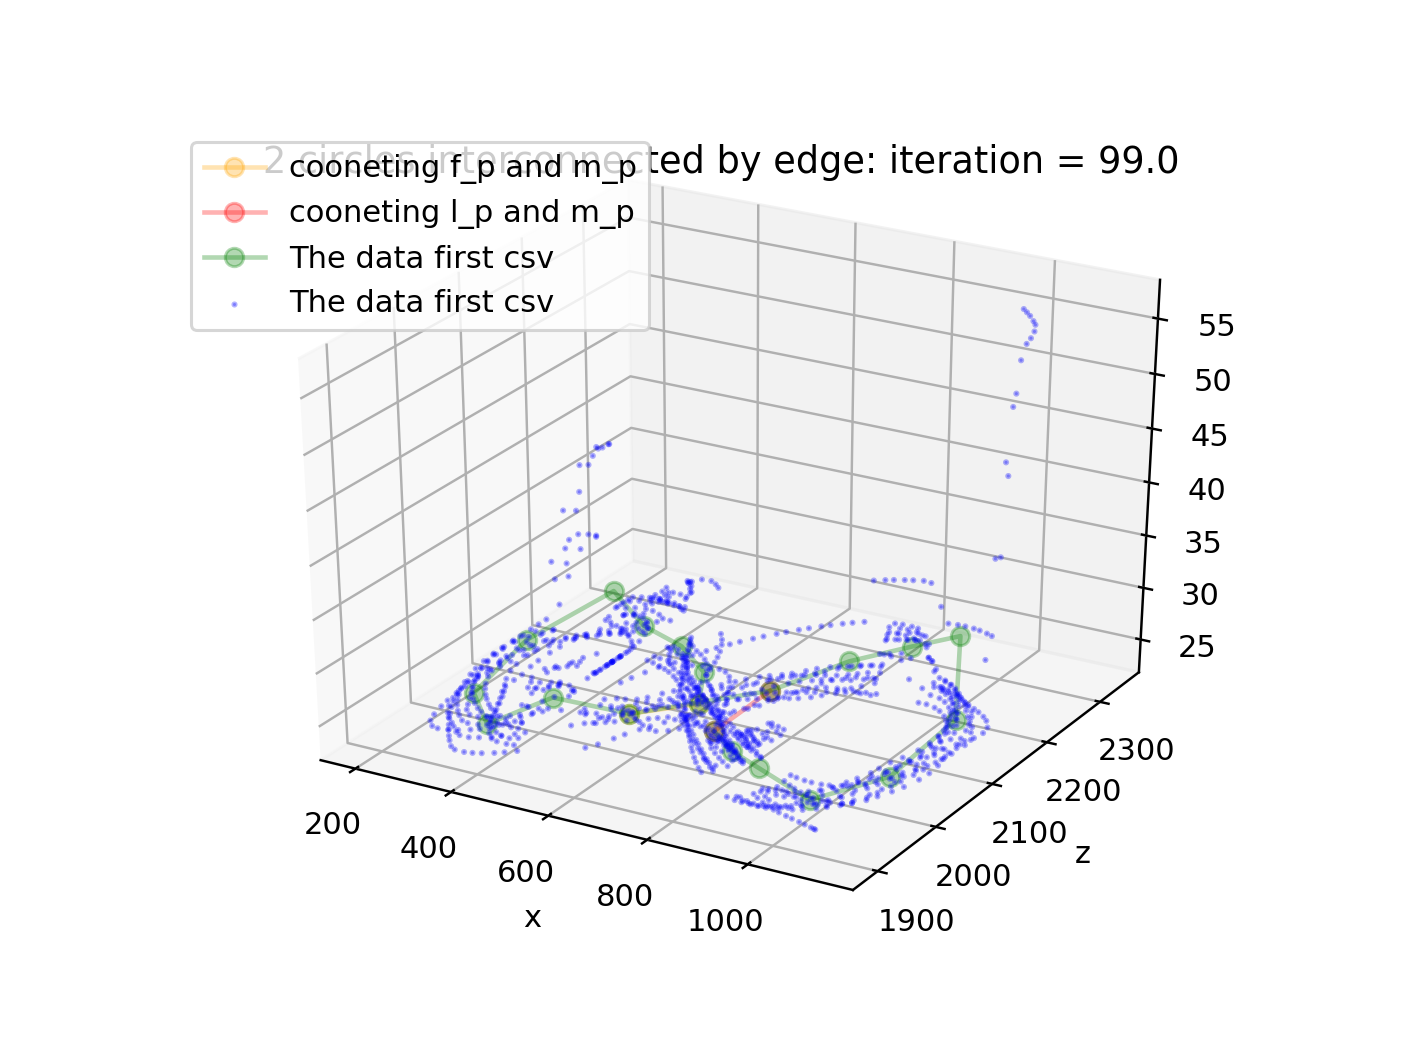

In [10]:
plot_SOM("q3dm1-path2.csv", batch = 'yes', max_iter = 100)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['1-0', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-0', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9']


<IPython.core.display.Javascript object>


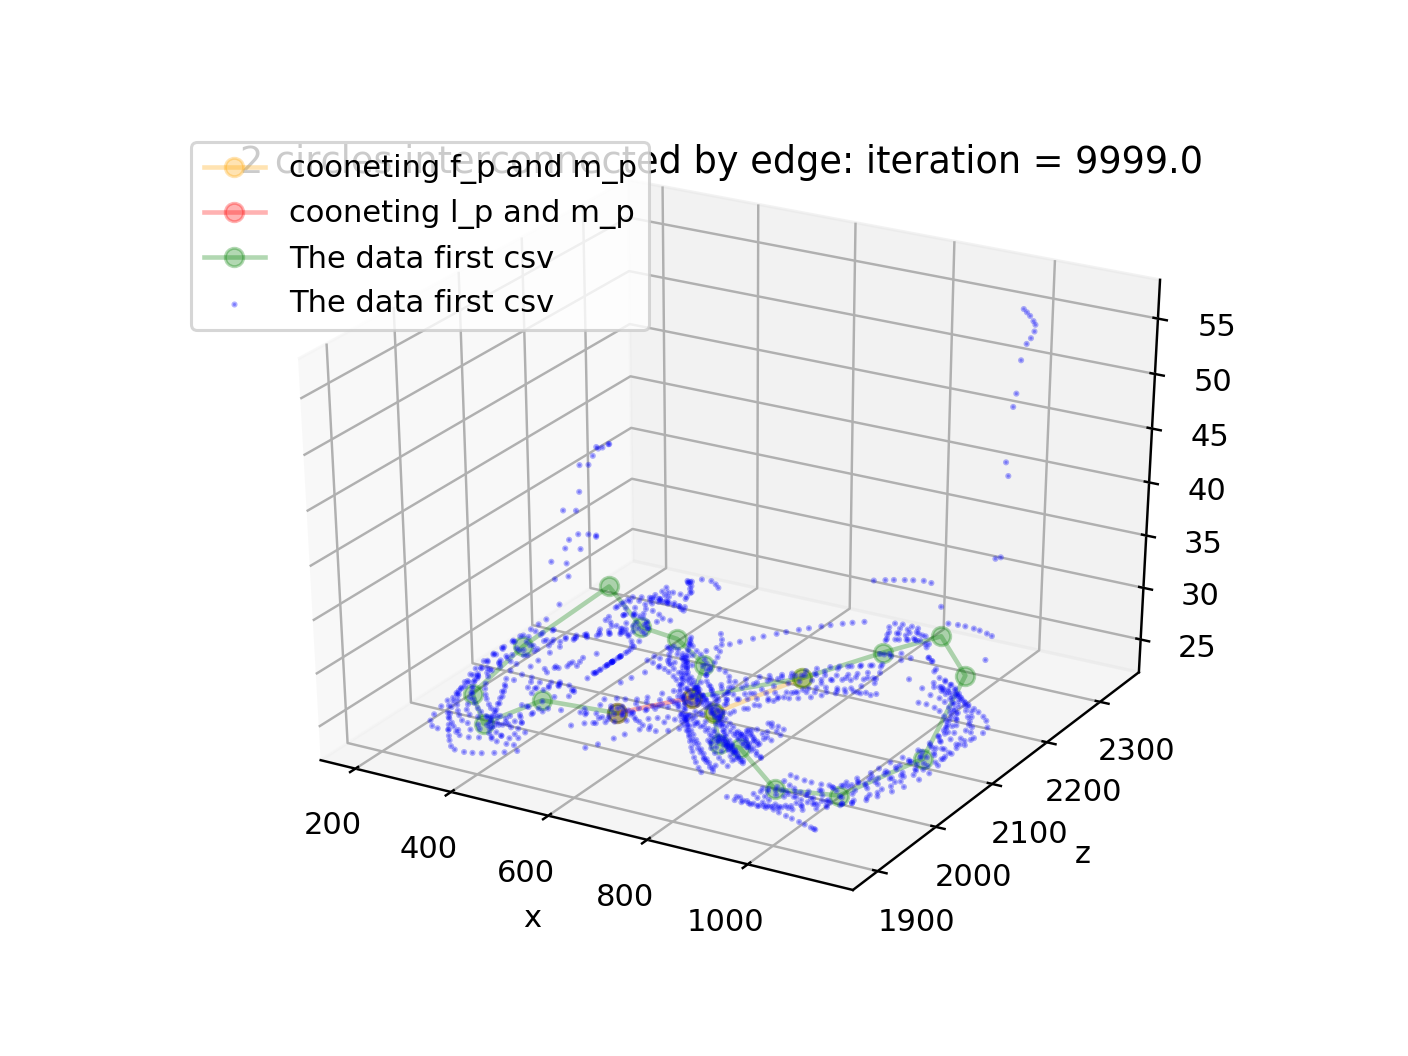

In [11]:
plot_SOM("q3dm1-path2.csv", batch = 'yes', max_iter = 10000)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['1-0', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-0', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9']


<IPython.core.display.Javascript object>


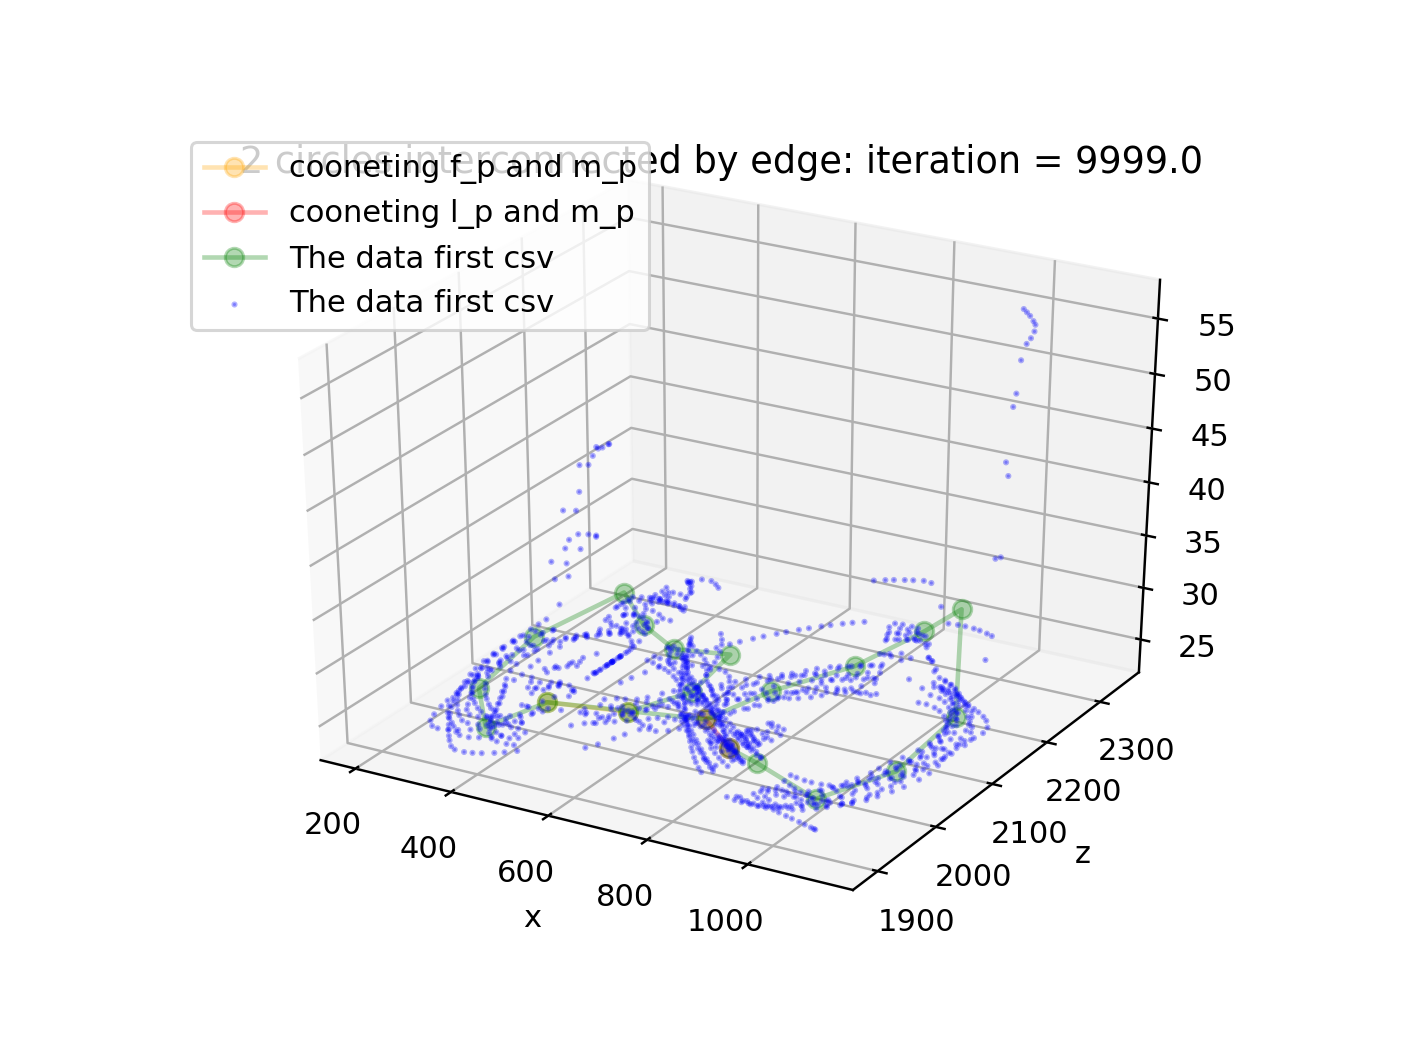

In [12]:
plot_SOM("q3dm1-path2.csv", max_iter = 10000)